<a href="https://colab.research.google.com/github/Mahdi-Saadati/Advanced-Machine-Learning-and-Deep-Neural-Networks/blob/main/11.d.%20Graph%20Neural%20Network%20(GNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div dir="rtl" align="right">

در این تصویر ما می‌خواهیم نشان دهیم:

هر بیمار (گره) ویژگی‌های خودش دارد

اطلاعات از گره‌های همسایه جمع می‌شود و به روزرسانی می‌شود

بعد از یک لایه GCN، هر گره ویژگی جدیدی دارد

Epoch 0, Loss = 0.7027
Epoch 20, Loss = 0.6703
Epoch 40, Loss = 0.6560
Epoch 60, Loss = 0.6319
Epoch 80, Loss = 0.5981


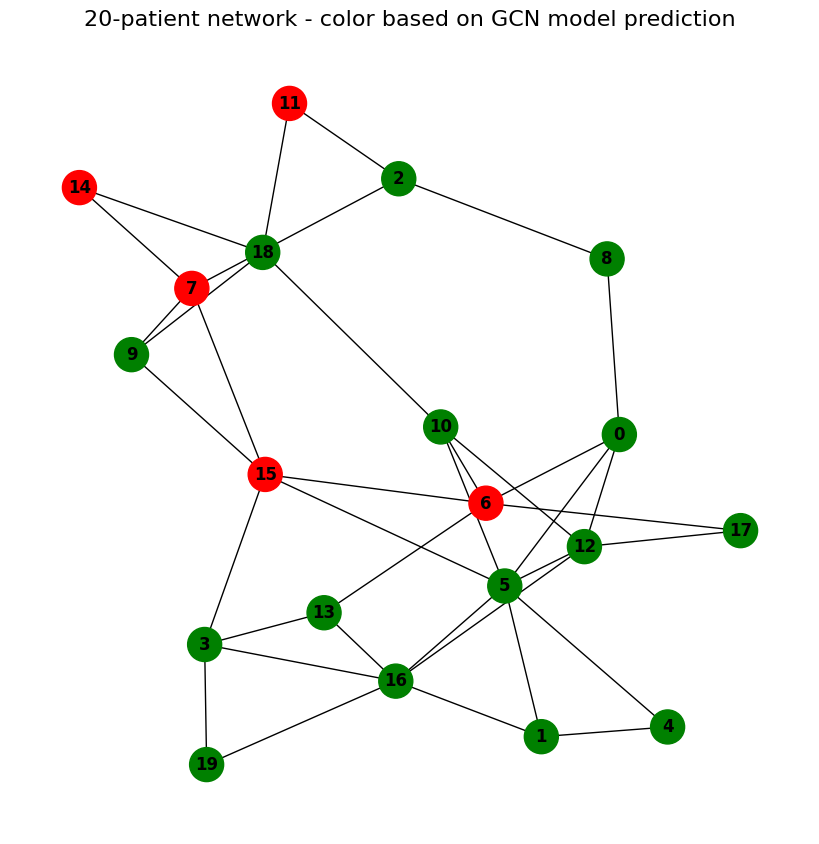

Actual patient labels: [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1]
GCN model prediction : [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


In [34]:
import torch                      # کتابخانه اصلی PyTorch
import torch.nn.functional as F   # توابع آماده مثل ReLU و log_softmax
from torch_geometric.nn import GCNConv  # لایه شبکه عصبی گرافی
from torch_geometric.data import Data   # ساختار داده گراف در PyG
import networkx as nx             # رسم گراف
import matplotlib.pyplot as plt   # نمایش گراف
import random                     # تولید اعداد تصادفی

# -----------------------------
# 1. ایجاد داده برای 20 بیمار
# -----------------------------
num_patients = 20

# ویژگی‌ها: فشار خون, قند خون, سن (0 یا 1 به صورت تصادفی)
torch.manual_seed(42)   # ثابت کردن تصادفی‌ها برای تکرارپذیری
x = torch.randint(0, 2, (num_patients, 3)).float()  # ماتریس ویژگی: 20×3

# برچسب واقعی بیماری قلبی (0=سالم, 1=بیمار) به صورت تصادفی
y = torch.randint(0, 2, (num_patients,), dtype=torch.long)

# ساخت یال‌ها (ارتباط بیماران)
# هر بیمار با 2 بیمار دیگر به صورت تصادفی ارتباط دارد
edges = []
for i in range(num_patients):
    neighbors = random.sample([j for j in range(num_patients) if j != i], 2)
    for n in neighbors:
        edges.append([i, n])
        edges.append([n, i])  # گراف بدون جهت است → دو طرفه

# تبدیل لیست یال‌ها به tensor [2, num_edges]
edge_index = torch.tensor(edges, dtype=torch.long).t()

# ماسک آموزش: فقط 10 بیمار اول برای آموزش
train_mask = torch.zeros(num_patients, dtype=torch.bool)
train_mask[:10] = True

# ساخت گراف داده
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)

# -----------------------------
# 2. تعریف مدل GCN
# -----------------------------
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 8)  # لایه اول: 3 ویژگی → 8 نورون مخفی
        self.conv2 = GCNConv(8, 2)  # لایه دوم: 8 نورون → 2 کلاس (سالم/بیمار)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)  # اعمال لایه اول
        x = F.relu(x)                  # فعال‌سازی ReLU
        x = self.conv2(x, edge_index)  # لایه دوم
        return F.log_softmax(x, dim=1) # احتمال کلاس‌ها با log_softmax

# ساخت مدل
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# -----------------------------
# 3. آموزش مدل
# -----------------------------
for epoch in range(100):
    model.train()                     # حالت آموزش
    optimizer.zero_grad()             # صفر کردن گرادیان‌ها
    out = model(data.x, data.edge_index)  # پیش‌بینی ویژگی‌های جدید
    # محاسبه خطا فقط روی گره‌های آموزشی
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()                   # محاسبه گرادیان‌ها
    optimizer.step()                  # بروزرسانی وزن‌ها
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss = {loss:.4f}")

# -----------------------------
# 4. پیش‌بینی مدل
# -----------------------------
model.eval()                          # حالت تست
pred = model(data.x, data.edge_index).argmax(dim=1)  # انتخاب کلاس با بیشترین احتمال

# -----------------------------
# 5. رسم گراف با پیش‌بینی
# -----------------------------
G = nx.Graph()
for i in range(edge_index.shape[1]):
    G.add_edge(int(edge_index[0,i]), int(edge_index[1,i]))  # اضافه کردن یال‌ها

# رنگ گره‌ها بر اساس پیش‌بینی مدل (بیمار=قرمز, سالم=سبز)
color_map = ['red' if label==1 else 'green' for label in pred]

plt.figure(figsize=(8,8))
nx.draw(G, with_labels=True, node_color=color_map, node_size=600, font_size=12, font_weight='bold')
plt.title("20-patient network - color based on GCN model prediction", fontsize=16) #شبکه 20 بیمار - رنگ بر اساس پیش‌بینی مدل GCN
plt.show()

# نمایش مقایسه واقعی و پیش‌بینی
print("Actual patient labels:", y.tolist())
print("GCN model prediction :", pred.tolist())


<div dir="rtl" align="right">

🔹 توضیح بصری:

هر بیمار یک گره است و ویژگی‌هایی دارد (مثل فشار خون، قند خون، سن).

یال‌ها ارتباط بین بیماران را نشان می‌دهند (خانواده یا محیط مشترک).

GCN ویژگی‌های هر بیمار را با همسایه‌هایش ترکیب می‌کند تا ویژگی‌های جدید بسازد.

مدل با داده آموزشی (train_mask) یاد می‌گیرد که چه ترکیبی از ویژگی‌ها باعث بیماری قلبی می‌شود.

بعد از آموزش، مدل می‌تواند وضعیت بیماری همه بیماران را پیش‌بینی کند.

این نشان می‌دهد که هر گره ویژگی‌هایش را با همسایه‌هایش ترکیب کرده است.